In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, 
                             precision_recall_curve, plot_precision_recall_curve, f1_score, average_precision_score, 
                             hinge_loss, precision_score, recall_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_breast_cancer, load_digits, fetch_openml, load_iris, make_moons, make_blobs
from sklearn.multiclass import OneVsRestClassifier
from scipy import stats
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# 2. Przykład dziłania SVM dla zbiorów WBC (WBreast cancer), MNIST, FMNIST - 500 elementów

In [4]:
# WBC
cancer = load_breast_cancer()

cancer_zipped = list(zip(cancer.data, cancer.target))
cancer_random_sample = random.sample(cancer_zipped, 500)
X, Y = zip(*(cancer_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy score: {accuracy_score(y_test,y_pred)}')

accuracy score: 0.96


In [5]:
# MNIST
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

mnist_zipped = list(zip(mnist.data, mnist.target))
mnist_random_sample = random.sample(mnist_zipped, 500)
X, Y = zip(*(mnist_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy score: {accuracy_score(y_test,y_pred)}')

accuracy score: 0.86


In [6]:
# FMNIST
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)

fmnist_zipped = list(zip(fmnist.data, fmnist.target))
fmnist_random_sample = random.sample(fmnist_zipped, 500)
X, Y = zip(*(fmnist_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy score: {accuracy_score(y_test,y_pred)}')

accuracy score: 0.8


In [7]:
# 3. Porównianie kerneli dla powyższych zbiorów. 

In [8]:
def accuracy(dataset, kernel):
    dataset_zipped = list(zip(dataset.data, dataset.target))
    dataset_random_sample = random.sample(dataset_zipped, 500)
    X, Y = zip(*(dataset_random_sample))
    X = np.asarray(X)
    Y = np.asarray(Y)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

    clf = SVC(kernel='linear')
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    
    return accuracy_score(y_test,y_pred)

In [9]:
frame_data = []

for kernel in ('linear', 'poly', 'rbf'):
    frame_data.append([kernel, accuracy(cancer, kernel), accuracy(mnist, kernel), accuracy(fmnist, kernel)])

                  
frame = pd.DataFrame(frame_data, columns=["kernel", "cancer", "mnist", "fmnist"])
frame

,kernel,cancer,mnist,fmnist
0,linear,1.00,0.94,0.74
1,poly,0.94,0.86,0.72
2,rbf,0.94,0.86,0.82


In [10]:
# 3. Ćwiczenie (tu dybczako wstawia swoje <3)

In [ ]:
# 4 i 5. Wizualizacja accuracy, cross validation, loss, ROC curve, PR curve dla zbioru WBC

In [11]:
cancer = load_breast_cancer()

X, y = (cancer.data, cancer.target)

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [12]:
# accuracy:
clf = SVC(kernel='linear', probability=True)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy = {accuracy_score(y_test,y_pred)}')

accuracy = 0.965034965034965


In [13]:
#cross validation
scores = cross_val_score(clf, X, y, cv=5)
print(f'cross validations scores:{scores}')

cross validations scores:[0.94736842 0.92982456 0.97368421 0.92105263 0.95575221]


In [14]:
#loss użyto funkcji hinge która jest stosowana w SVM
print(f'hinge function loss: {hinge_loss(y_test, y_pred)}')

hinge function loss: 0.3706293706293706


In [19]:
# precision score
print(f'precision score: {precision_score(y_test, y_pred)}')

precision score: 0.9591836734693877


In [21]:
# recall score
print(f'recall score: {recall_score(y_test, y_pred)}')

recall score: 0.9894736842105263


In [22]:
# f1 score
print(f'f1 score: {f1_score(y_test, y_pred)}')

f1 score: 0.9740932642487047


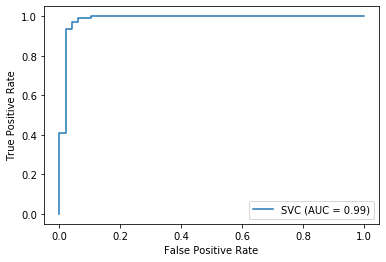

In [15]:
# ROC curve
# Binarize the output
svc_disp = plot_roc_curve(clf, x_test, y_test)
plt.show()

Average precision score, micro-averaged over all classes: 0.97


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.97')

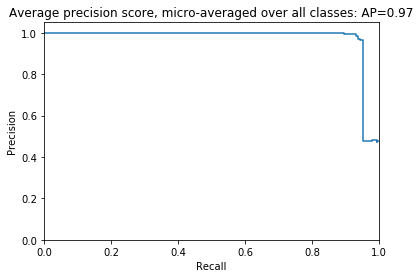

In [16]:
# PR_curve
y_binarized = label_binarize(y, classes=[0, 1, 2])
n_classes = y_binarized.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, y_binarized, train_size=0.75)

# Run classifier
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True))
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

In [ ]:
# 6a. Na zbiorach MNIST, FMNIST, TNG (twenty news groups) zaprezentować działanie
# klasyfikatora SVM i wyniki porównać do klasyfikatora k-NN przy pomocy poznanych miar
# walidacji klasyfikacji. (dla najlepszej konfiguracji, stałej uczenia, funkcji kernela)

In [17]:
# 6b. Zaproponować, taką augmentację zbiorów treningowych (wielkość zbioru zależna od
# mocy obliczeniowej którą Państwo dysponują) aby uzyskać jak najlepsze miary jakości na
# zbiorach testowych.